In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy
import en_core_web_sm

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt


nlp =spacy.load(r'C:/Users/syful/Anaconda3/Lib/site-packages/en_core_web_sm/en_core_web_sm-2.2.5')

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])


df = pd.read_csv("D:/1_NAIST_RESEARCH/SE_meeting/NS/01_NS_posts.csv")
print(df.Title.unique())
df.head()


# Convert to list
data = df.Title.values.tolist()


# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])


def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])


# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])


# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
#nlp = en_core_web_sm.load('en', disable=['parser', 'ner'])
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# Build LDA model
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

# Visualize the topics
#pyLDAvis.enable_notebook()
#vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
#vis

#pyLDAvis.save_html(vis, 'D:/1_NAIST_RESEARCH/SE_meeting/stackoverflow/lda.html')

['No drop packets using the error models for wireless scenario?'
 'How can I monitor a flow over wireless connection?'
 'How to Set the MTU(Maximum Transmission unit) in NS2?' ...
 'Omnetpp INET error: Mobility position is not a finite number after initialize'
 'Implementation of s-mac protocol'
 'How to send a packet to a specific node in the network using UDPSocket in inet']
['No drop packets using the error models for wireless scenario?']
[['no', 'drop', 'packets', 'using', 'the', 'error', 'models', 'for', 'wireless', 'scenario']]
['no', 'drop', 'packets', 'using', 'the', 'error', 'models', 'for', 'wireless', 'scenario']
[['drop', 'packet', 'use', 'error', 'model', 'wireless', 'scenario']]
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]]
[(0,
  '0.549*"omnet" + 0.135*"send" + 0.081*"function" + 0.073*"different" + '
  '0.040*"simulate" + 0.015*"protocol" + 0.002*"single" + 0.001*"boost" + '
  '0.000*"operator" + 0.000*"vein"'),
 (1,
  '0.227*"project" + 0.136*"class" + 0.1

In [28]:
import os
## Setup mallet environment change it according to your drive
os.environ.update({'MALLET_HOME':r'C:/mallet/'})
## Setup mallet path change it according to your drive
mallet_path = 'C:/mallet/bin/mallet'

## Train LDA with mallet
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=8, alpha=7, id2word=id2word,workers=4, prefix=None, optimize_interval=0, iterations=1000, topic_threshold=0.0, random_seed=0)
#ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.4872854523426777


In [29]:
#pprint(ldamallet.show_topics(formatted=False))
print(ldamallet.print_topics(num_words=20))

[(0, '0.103*"packet" + 0.099*"message" + 0.080*"send" + 0.052*"node" + 0.038*"receive" + 0.031*"application" + 0.027*"multiple" + 0.023*"datum" + 0.023*"specific" + 0.019*"server" + 0.018*"traffic" + 0.018*"layer" + 0.015*"communication" + 0.014*"data" + 0.013*"drop" + 0.013*"rate" + 0.012*"graph" + 0.011*"start" + 0.010*"range" + 0.010*"event"'), (1, '0.166*"file" + 0.047*"set" + 0.045*"parameter" + 0.039*"module" + 0.039*"number" + 0.034*"trace" + 0.022*"generate" + 0.021*"script" + 0.020*"random" + 0.017*"position" + 0.017*"access" + 0.017*"give" + 0.016*"connection" + 0.015*"show" + 0.013*"execute" + 0.013*"output" + 0.012*"write" + 0.011*"pass" + 0.010*"modify" + 0.010*"cc"'), (2, '0.109*"node" + 0.100*"network" + 0.059*"create" + 0.050*"wireless" + 0.043*"simulator" + 0.039*"simulate" + 0.033*"omnet" + 0.019*"model" + 0.018*"connect" + 0.018*"sensor" + 0.017*"simple" + 0.015*"issue" + 0.015*"address" + 0.014*"interface" + 0.013*"mobile" + 0.013*"host" + 0.011*"system" + 0.011*"re

In [16]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.43452342110591946


In [9]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, alpha=int(50/num_topics)+1, id2word=id2word,workers=4, prefix=None, optimize_interval=0, iterations=1000, topic_threshold=0.0, random_seed=0)

        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [10]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=50, step=3)

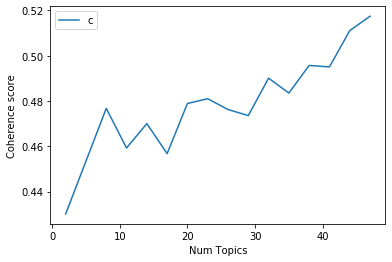

In [11]:
limit=50; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [12]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
    

Num Topics = 2  has Coherence Value of 0.4302
Num Topics = 5  has Coherence Value of 0.4534
Num Topics = 8  has Coherence Value of 0.4768
Num Topics = 11  has Coherence Value of 0.4593
Num Topics = 14  has Coherence Value of 0.47
Num Topics = 17  has Coherence Value of 0.4568
Num Topics = 20  has Coherence Value of 0.4789
Num Topics = 23  has Coherence Value of 0.481
Num Topics = 26  has Coherence Value of 0.4762
Num Topics = 29  has Coherence Value of 0.4736
Num Topics = 32  has Coherence Value of 0.4901
Num Topics = 35  has Coherence Value of 0.4835
Num Topics = 38  has Coherence Value of 0.4957
Num Topics = 41  has Coherence Value of 0.4951
Num Topics = 44  has Coherence Value of 0.5111
Num Topics = 47  has Coherence Value of 0.5174


In [31]:
def format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)
df_dominant_topic.to_csv('D:/1_NAIST_RESEARCH/SE_meeting/NS/01_NS_posts_LDA.csv', header=True, index=False, encoding='utf-8') 
